Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
XGBoost - MAE: 49367.50, RMSE: 82071.09
MAE is 4.72% of average weekly sales
RMSE is 0.15 times the standard deviation of sales


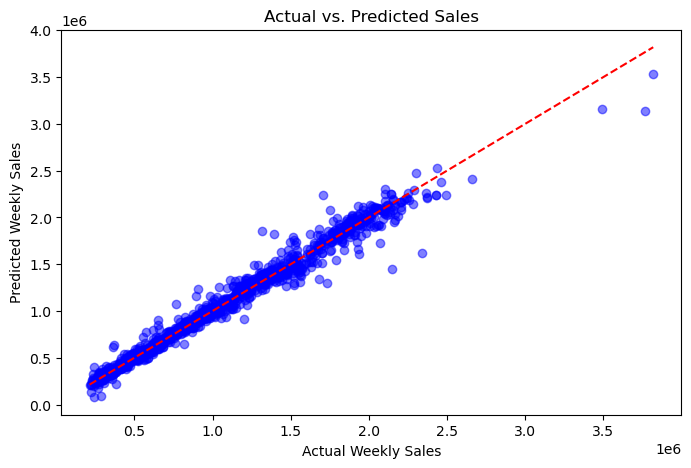

Model saved successfully!


In [127]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('Walmart_Sales.csv')

# Convert date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Extract date-related features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Drop original date column
df.drop(columns='Date', inplace=True)

# Define features and target variable
X = df.drop(columns=['Weekly_Sales'])  
y = df['Weekly_Sales'] 

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost regressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define hyperparameter search space
param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Perform randomized search for best parameters
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Number of random samples to try
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

# Train model with best parameters
best_xbg = random_search.best_estimator_
y_pred = best_xbg.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f'Best Parameters: {random_search.best_params_}')
print(f'XGBoost - MAE: {mae:.2f}, RMSE: {rmse:.2f}')

# Calculate error as a percentage of average sales
avg_sales = df['Weekly_Sales'].mean()
error_percentage = (mae / avg_sales) * 100
print(f"MAE is {error_percentage:.2f}% of average weekly sales")

# Calculate RMSE relative to standard deviation
std_sales = df['Weekly_Sales'].std()
print(f"RMSE is {rmse / std_sales:.2f} times the standard deviation of sales")

# Plot actual vs predicted values
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Actual vs. Predicted Sales")
plt.show()

import joblib  

# Save the trained model  
joblib.dump(best_xbg, 'xgboost_sales_model.pkl')  
print("Model saved successfully!")  
